# Knee X-ray Analysis Using ResNet for Osteoarthritis Severity Assessment

**By: Bernard Adhitya Kurniawan**

This is a quick demonstration on how to use a Convolutional Neural Network (CNN), specifically a pre-trained ResNet model, to analyze knee X-ray images and assess the severity of osteoarthritis using the Osteoarthritis Initiative (OAI) dataset.

## Step 1: Import Libraries
First, we need to import the necessary libraries for data handling, model building, training, and evaluation.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tqdm import tqdm


## Step 2: Load and Prepare the Dataset
We will create the function `load_dataset_as_dataframe()` to load the OAI dataset from the subdirectories prepared for us; `train/` and `test/`, and organize the image paths and labels.

- We traverse through each class folder (representing osteoarthritis severity grades; `['0', '1', '2', '3', '4']`) and collect image paths and corresponding labels.
- The classes list contains all the class names, and class_to_idx maps these class names to numeric labels.
- We create a DataFrame data for easier data manipulation.

In [2]:
def load_dataset_as_dataframe(subdir):
    # Define the path to the dataset
    data_dir = f'/models/knee_osteoarthrist/{subdir}'
    print(f'Load dataset from `{subdir}` subdirectory')

    # Create lists to store image paths and labels
    image_paths = []
    labels = []

    # Get the list of class directories
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    classes.sort()
    print('Classes:', classes)

    # Map class names to labels
    class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

    # Loop over each class directory
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        label = class_to_idx[class_name]
        # Get all image files in the class directory
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
                labels.append(label)

    # Create a DataFrame
    data = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })
    
    # Show the distribution of labels in the dataset
    dataset_distribution_dict = {}
    for i in range(5):
        dataset_distribution_dict[i] = len(data[data['label'] == i])
    print(dataset_distribution_dict)
    print()

    return data

## Step 3: Split the Dataset
Using the above function `load_dataset_as_dataframe()`, we'll load the test and train dataset as dataframe

In [3]:
# Prepare training and test dataset as dataframes
classes = ['0', '1', '2', '3', '4']
train_df = load_dataset_as_dataframe('train')
test_df = load_dataset_as_dataframe('test')

Load dataset from `train` subdirectory


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/models/knee_osteoarthrist/train'

## Step 4: Define Image Transformations
We define transformations for data augmentation and normalization.

* Images are resized to 224x224 pixels to match the input size expected by ResNet.
* Data augmentation is applied to the training set with random horizontal flips.
* Images are normalized using ImageNet mean and standard deviation values.

In [4]:
# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet standards
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


## Step 5: Create Custom Dataset Class
We create a custom dataset class to handle image loading and preprocessing.

* The `KneeDataset` class inherits from torch.utils.data.Dataset.
* The `__getitem__` method loads and returns an image and its label.

In [5]:
# Create custom dataset class
class KneeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


## Step 6: Create DataLoaders
We create DataLoader objects for batching and shuffling the data.

* `batch_size=32` specifies the number of samples per batch.
* `shuffle=True` randomizes the order of data every epoch in the training set.

In [6]:
# Create dataset instances
train_dataset = KneeDataset(train_df, transform=train_transform)
test_dataset = KneeDataset(test_df, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


## Step 7: Visualize Sample Images
We can visualize a batch of training images to verify the data loading and transformations.

* We define an `imshow` function to display images after unnormalizing them.
* We use `utils.make_grid` to create a grid of images.

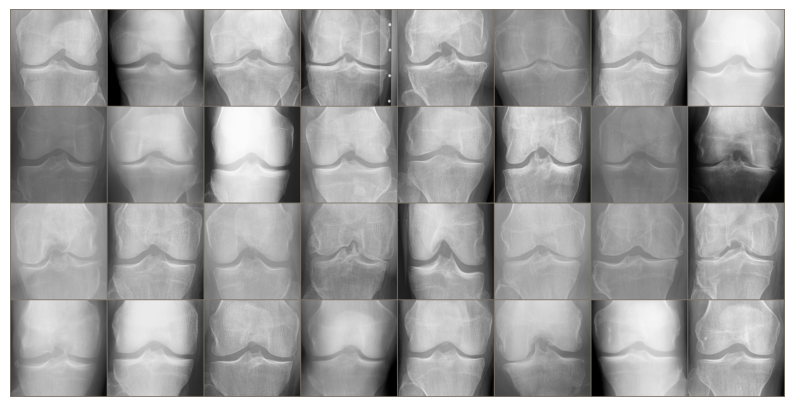

In [7]:
# Function to display images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img  = std * img + mean
    img  = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get a batch of training data
images, labels = next(iter(train_loader))

# Make a grid from batch
out = utils.make_grid(images)

# Display images
plt.figure(figsize=(10, 10))
imshow(out)
plt.show()


## Step 8: Load and Modify the Pre-trained ResNet Model
We load a pre-trained ResNet18 model and modify the final layer to match our number of classes.

* We replace the final fully connected layer (`model.fc`) to output the correct number of classes for our dataset.
* `pretrained=True` loads weights trained on ImageNet.

In [8]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final layer
num_ftrs = model.fc.in_features
num_classes = len(classes)
model.fc = nn.Linear(num_ftrs, num_classes)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Step 9: Define Loss Function and Optimizer
We set up the loss function and optimizer for training.

* `CrossEntropyLoss` is suitable for multi-class classification.
* `Adam` optimizer is used with a learning rate of 0.001.

In [9]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Step 10: Train the Model
We train the model for a few epochs.

* We iterate over the training data, compute the loss, perform backpropagation, and update the model weights.
* `model.train()` sets the model to training mode.

In [10]:
# Number of epochs
num_epochs = 25

# Training loop with progress bars
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    # Wrap the train_loader with tqdm for a progress bar
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item() * images.size(0)
        
        # Calculate accuracy within the batch
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        
        # Update progress bar description
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{(total_correct/total_samples*100):.2f}%'
        })
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = total_correct.double() / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch [1/25]: 100%|██████████| 145/145 [09:10<00:00,  3.80s/it, loss=1.0765, acc=48.07%]
Epoch [1/25], Loss: 1.2366, Accuracy: 0.4807
Epoch [2/25]: 100%|██████████| 145/145 [09:12<00:00,  3.81s/it, loss=1.5561, acc=56.17%]
Epoch [2/25], Loss: 1.0259, Accuracy: 0.5617
Epoch [3/25]: 100%|██████████| 145/145 [09:10<00:00,  3.79s/it, loss=0.4688, acc=60.80%]
Epoch [3/25], Loss: 0.9350, Accuracy: 0.6080
Epoch [4/25]: 100%|██████████| 145/145 [09:06<00:00,  3.77s/it, loss=0.9068, acc=63.31%]
Epoch [4/25], Loss: 0.8848, Accuracy: 0.6331
Epoch [5/25]: 100%|██████████| 145/145 [09:02<00:00,  3.74s/it, loss=0.9247, acc=64.86%]
Epoch [5/25], Loss: 0.8489, Accuracy: 0.6486
Epoch [6/25]: 100%|██████████| 145/145 [09:20<00:00,  3.87s/it, loss=0.9817, acc=65.95%]
Epoch [6/25], Loss: 0.8087, Accuracy: 0.6595
Epoch [7/25]: 100%|██████████| 145/145 [09:25<00:00,  3.90s/it, loss=1.0051, acc=67.50%]
Epoch [7/25], Loss: 0.7762, Accuracy: 0.6750
Epoch [8/25]: 100%|██████████| 145/145 [09:29<00:00,  3.93s/it

## Step 11: Evaluate the Model
We test the model on the test set and evaluate its performance.

* `model.eval()` sets the model to evaluation mode.
* We disable gradient computation with `torch.no_grad()`.
* We collect all predictions and true labels to compute accuracy and generate reports.
* The confusion matrix and classification report provide detailed insights into model performance.

Accuracy on test set: 0.9457
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       639
           1       0.95      0.97      0.96       296
           2       0.96      0.94      0.95       447
           3       0.90      0.98      0.94       223
           4       0.66      0.92      0.77        51

    accuracy                           0.95      1656
   macro avg       0.89      0.95      0.91      1656
weighted avg       0.95      0.95      0.95      1656

Confusion Matrix:
[[595   7  13  13  11]
 [  3 288   2   1   2]
 [  5   4 418   9  11]
 [  1   3   1 218   0]
 [  0   2   2   0  47]]


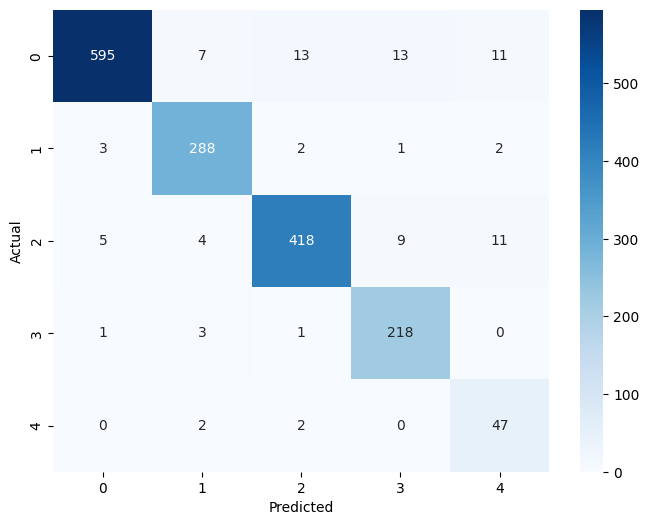

In [11]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on test set: {accuracy:.4f}')

# Classification report
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
